In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw

In [19]:
x_lattice = 300
y_lattice = 300

tau = 0.53

In [20]:
nodes = 9

In [21]:
x_discrete_velocity = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
x_discrete_velocity_1b9 = x_discrete_velocity.reshape(9, 1, 1)
y_discrete_velocity = np.array([0, 1, 1, 0,-1,-1, -1,  0,  1])
y_discrete_velocity_1b9 = y_discrete_velocity.reshape(9, 1, 1)
weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])

In [22]:
x_discrete_velocity_1b9

array([[[ 0]],

       [[ 0]],

       [[ 1]],

       [[ 1]],

       [[ 1]],

       [[ 0]],

       [[-1]],

       [[-1]],

       [[-1]]])

In [61]:
F = np.ones((nodes, y_lattice, x_lattice)) #+ 0.1*np.random.randn(9, y_lattice, x_lattice)
F[3, -1, :] = 3
#F[3, int(y_lattice/2 - y_lattice/10):int(y_lattice/2 + y_lattice/10), 0:int(x_lattice/10)] = 3
#F[7, 950:1050, 3900:4000] = 3

In [62]:
cylinder = np.full((y_lattice, x_lattice), False)
cylinder

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [63]:
def distance(y1, x1, y2, x2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [64]:
for y in range(y_lattice):
    for x in range(x_lattice):
        if (distance(y_lattice/2, x_lattice/10, y, x)<x_lattice/10):
            cylinder[y][x] = True 

In [65]:

cylinder_boundary_F = F[:, cylinder]
cylinder_boundary_F = cylinder_boundary_F[[0, 5, 6, 7, 8, 1, 2, 3, 4], :]



In [66]:
times = 1000
velocity_frames = np.zeros([100, y_lattice, x_lattice])

In [67]:
for t in range(times):
    
    
    F[:, :, 0] = F[[0, 5, 6, 7, 8, 1, 2, 3, 4], :, 0]
    F[:, :, -1] = F[[0, 5, 6, 7, 8, 1, 2, 3, 4], :, -1]
    F[:, 0, :] = F[[0, 5, 6, 7, 8, 1, 2, 3, 4], 0, :]
    
    
    '''
    F[[6, 7, 8], :, -1] = F[[6, 7, 8], :, -2]
    F[[2, 3, 4], :, 0] = F[[2, 3, 4], :, 1]
    
    #F[[8, 1, 2,], -1, :] = F[[8, 1, 2], -2, :]
    F[[5, 6, 7], 0, :] = F[[5, 6, 7], 1, :]
    '''
    
    
    for i in range(nodes):
        F[i, :, :] = np.roll(np.roll(F[i, :, :], x_discrete_velocity[i], axis=1), y_discrete_velocity[i], axis=0)
    
    
    '''
    cylinder_boundary_F = F[:, cylinder]
    cylinder_boundary_F = cylinder_boundary_F[[0, 5, 6, 7, 8, 1, 2, 3, 4], :]
    '''
    
    rho = np.sum(F, 0)
    ux = np.sum(F * x_discrete_velocity_1b9, 0)/rho
    uy = np.sum(F * y_discrete_velocity_1b9, 0)/rho
    
    '''
    F[:, cylinder] = cylinder_boundary_F
    ux[cylinder] = 0
    uy[cylinder] = 0
    '''
    
    Feq = np.zeros(F.shape)
    for i in range(nodes):
        Feq[i, :, :,] = rho * weights[i] * (1 + 3 * (x_discrete_velocity[i]*ux + y_discrete_velocity[i]*uy) +\
                                           9 * (x_discrete_velocity[i]*ux + y_discrete_velocity[i]*uy)**2 /2 -\
                                           3 * (ux**2 + uy**2)/2)
    F = F - (1/tau) * (F - Feq)
    
    velocity_magnitude = np.sqrt(ux**2 + uy**2)
    
    
    
    if t%10 == 0:
        velocity_frames[int(t/10)] = velocity_magnitude
    
    
    

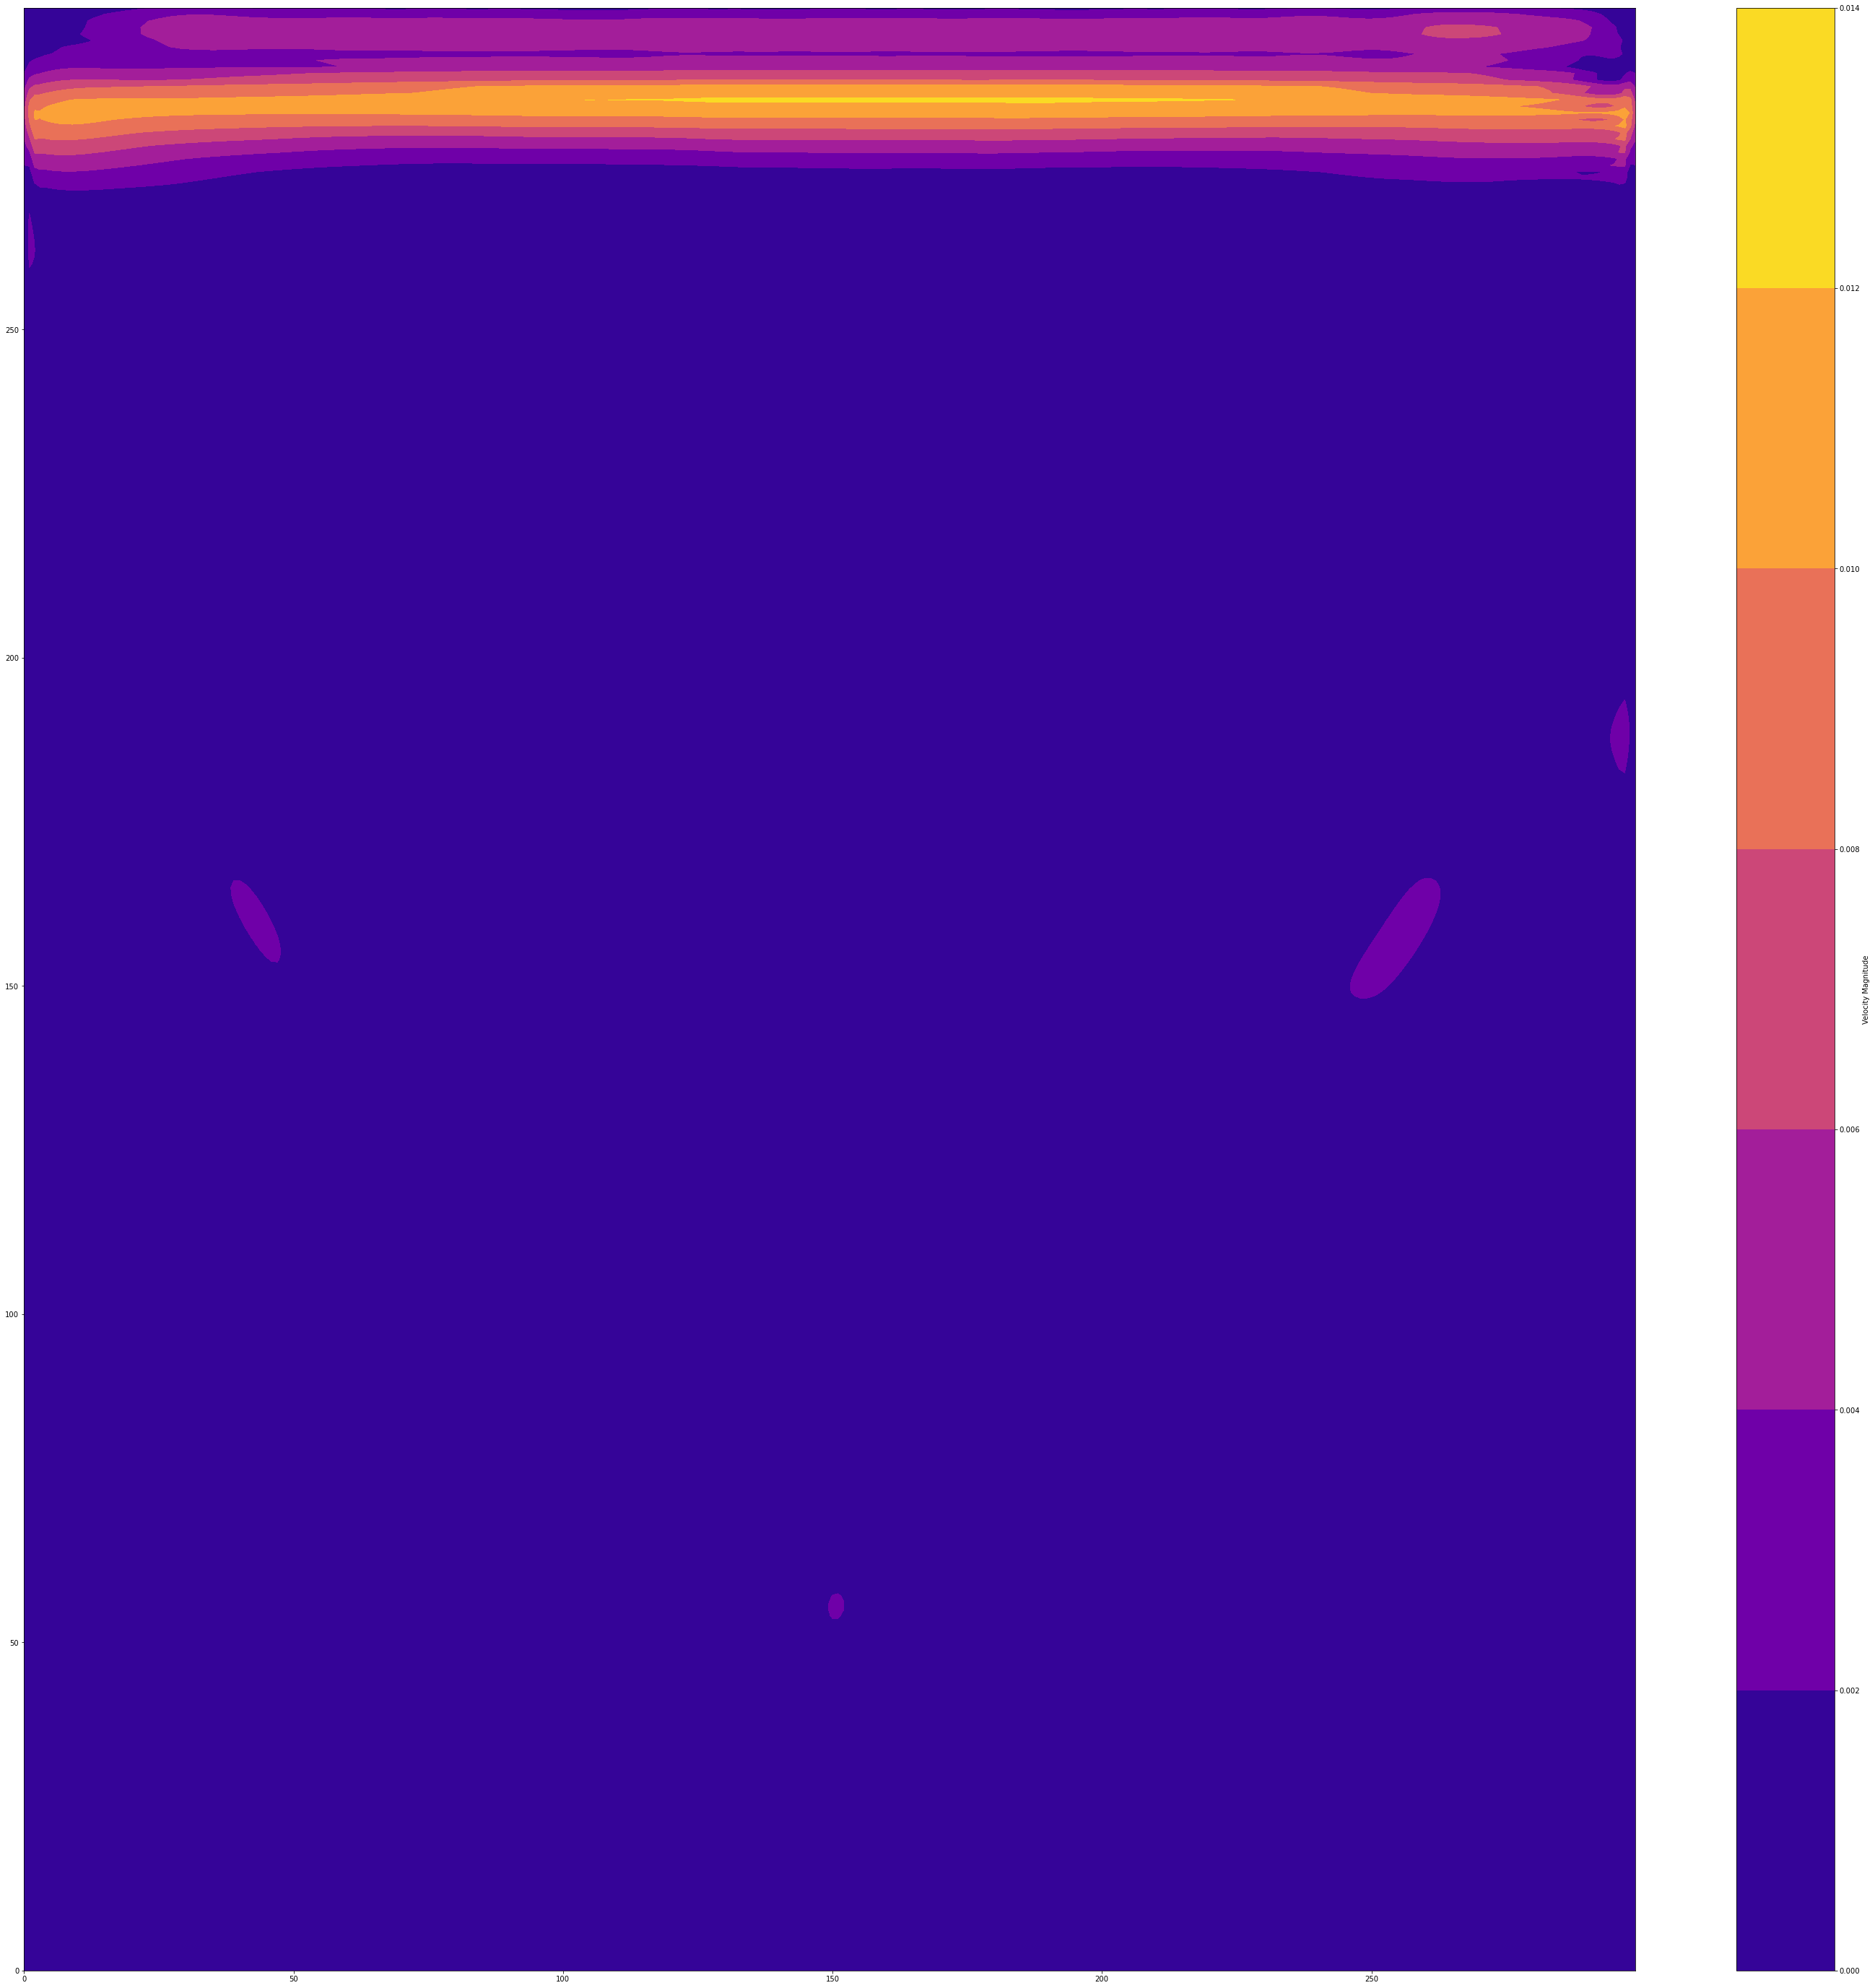

In [68]:
plt.figure(figsize=(50,50))
plt.contourf(range(x_lattice), range(y_lattice), velocity_magnitude, cmap='plasma')
plt.colorbar(label='Velocity Magnitude')

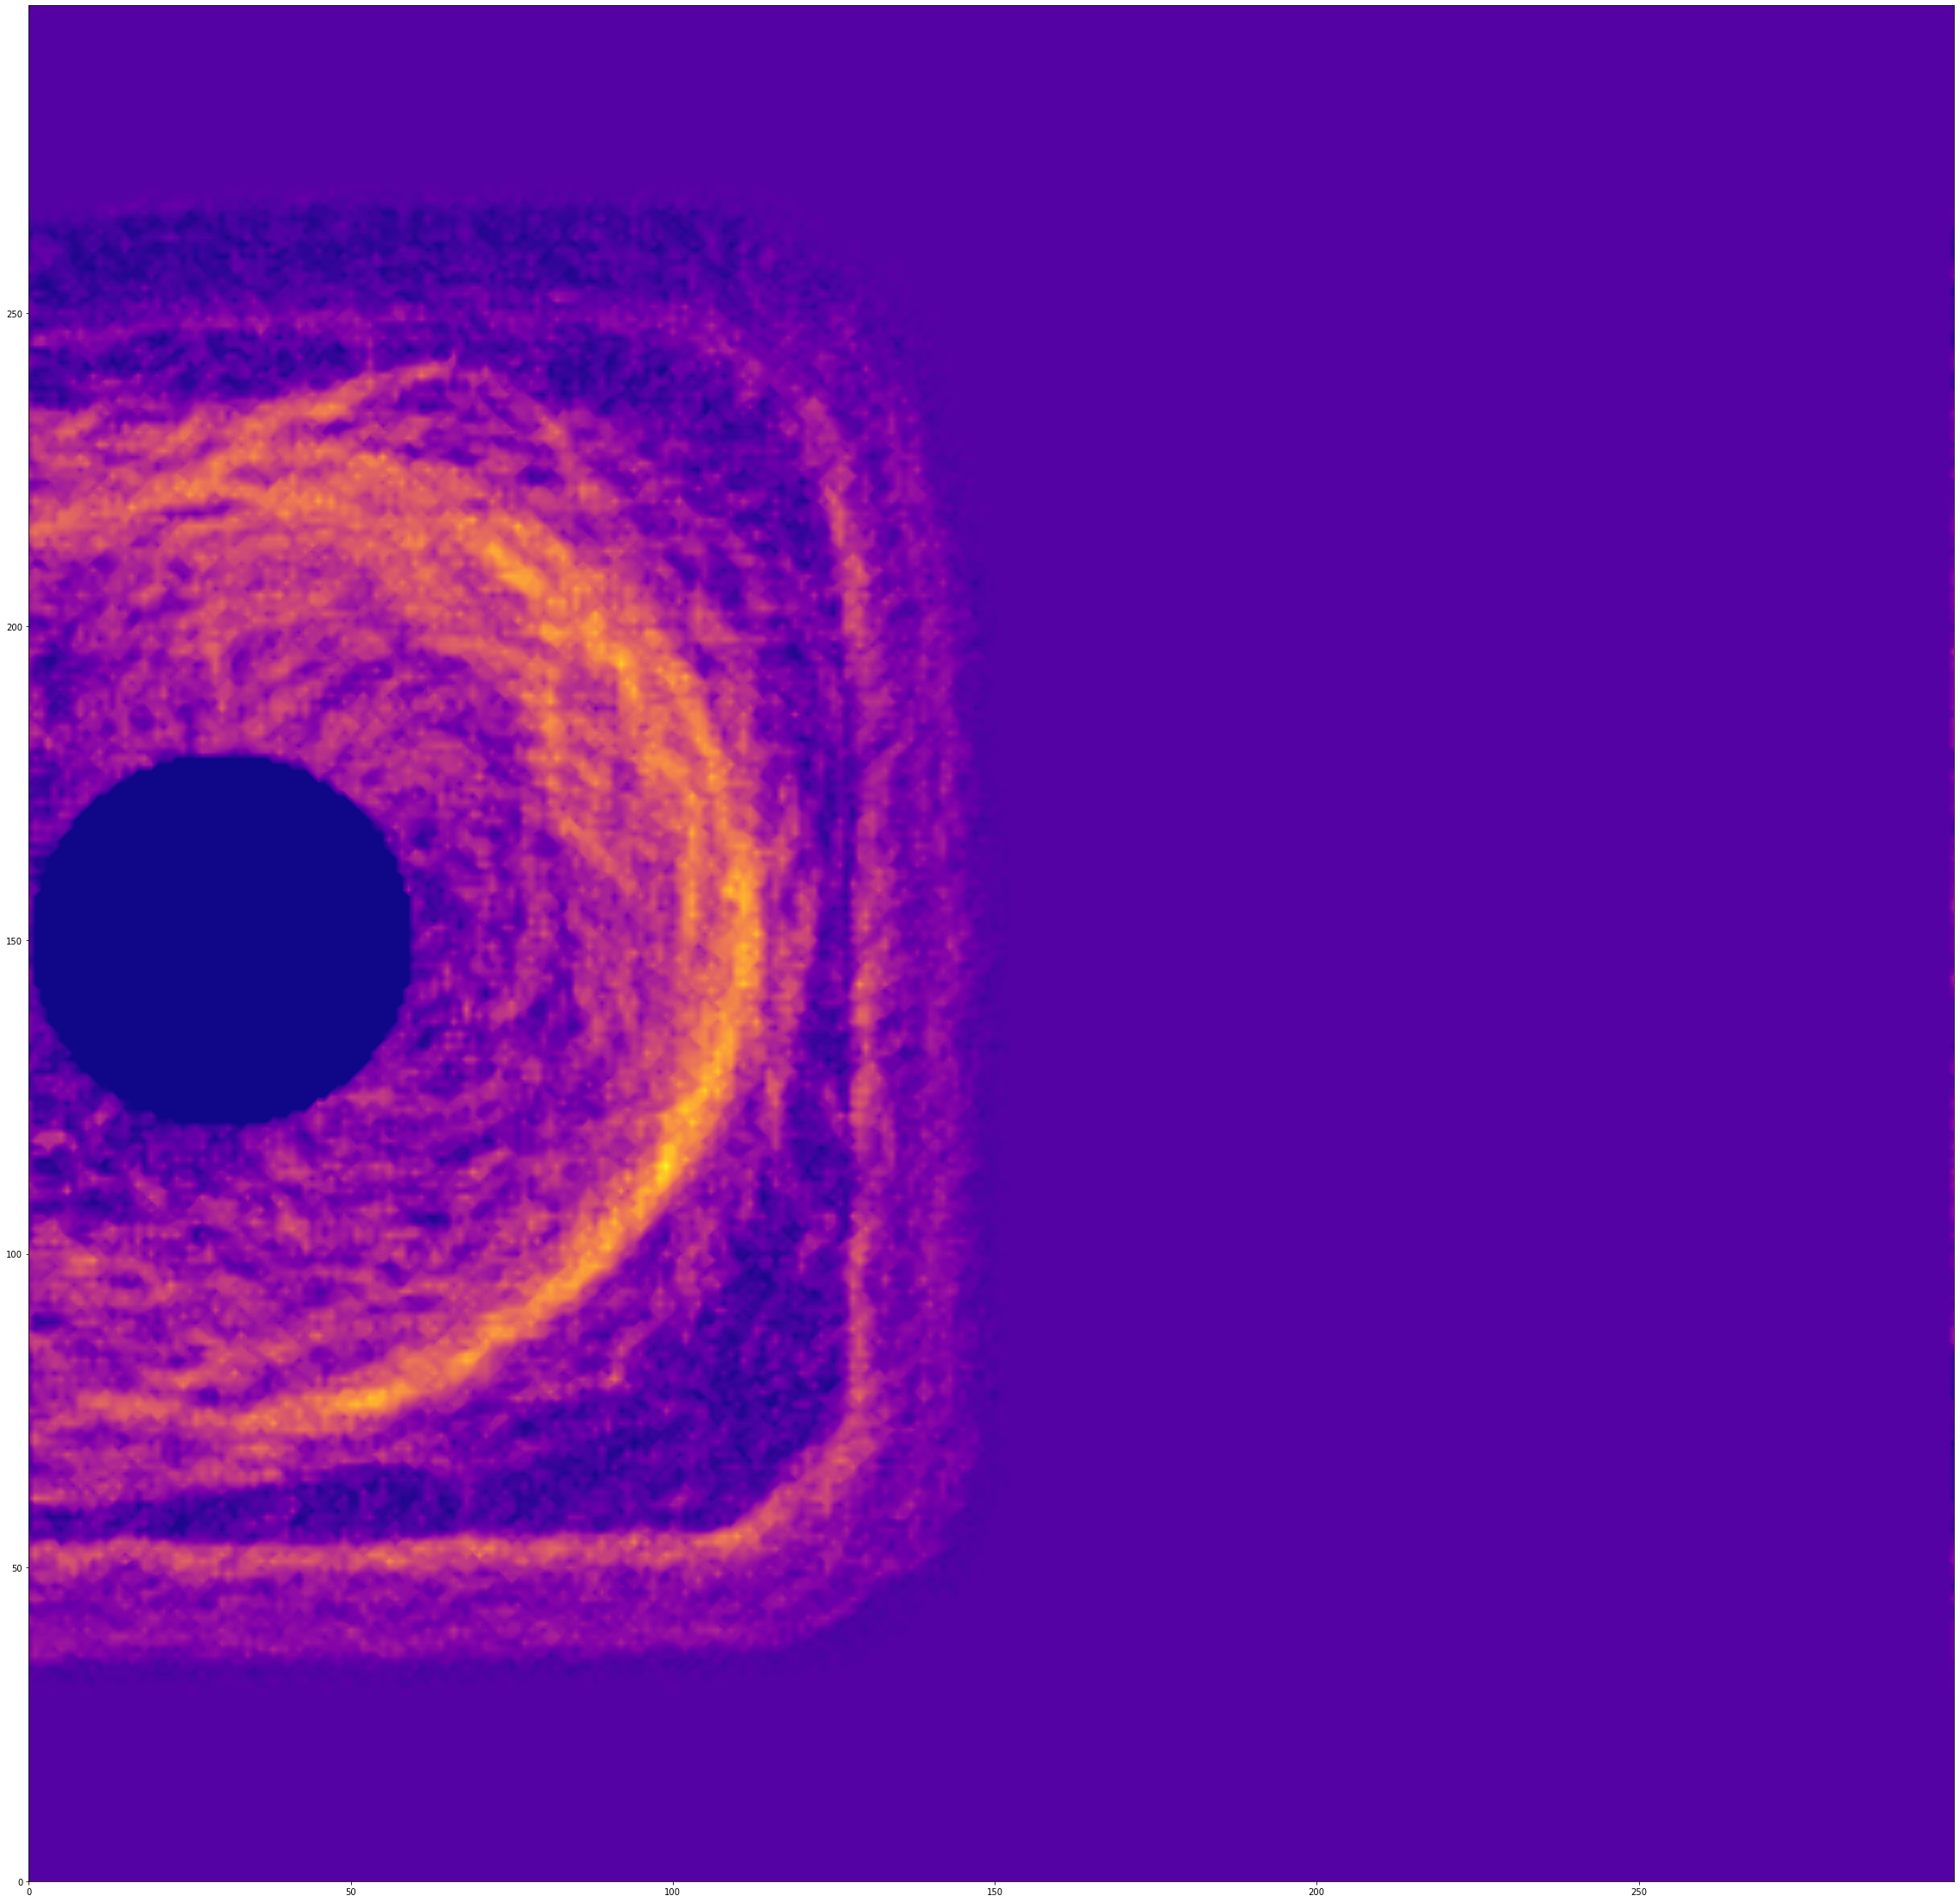

In [87]:
def animate(i):
    ax.clear()
    ax.contourf(velocity_frames[i], 100, cmap='plasma')
    return fig,

fig, ax = plt.subplots(figsize=(40,40))
ani = animation.FuncAnimation(fig, animate, frames=100)


ani.save('LidDrivenCavity.gif', writer='pillow', fps=5)
